## Compare grit as calculated with two different plate normalization schemes

* Whole plate normalization
* Control-based normalization

In [1]:
import pathlib
import numpy as np
import pandas as pd
import plotnine as gg

In [2]:
cell_line_colors = {
  "A549": "#861613",
  "ES2": "#1CADA8",
  "HCC44": "#2A364D"
}

grit_theme = gg.theme(
    strip_background=gg.element_rect(color="black", fill="#fdfff4"),
    strip_text_x=gg.element_text(size=7),
    strip_text_y=gg.element_text(size=8),
    axis_text=gg.element_text(size=7),
    axis_title=gg.element_text(size=8),
    legend_title=gg.element_text(size=6),
    legend_text=gg.element_text(size=5),
    legend_key_size=10,
    legend_key_width=10,
    legend_key_height=10,
    panel_grid=gg.element_line(size=0.35)
)

In [3]:
results_dir = pathlib.Path("../../1.calculate-metrics/cell-health/results")
output_dir = pathlib.Path("figures/plate_normalization")

In [4]:
# Load cell health grit scores with control normalization
grit_file = pathlib.Path(f"{results_dir}/cell_health_grit.tsv")

grit_df = pd.read_csv(grit_file, sep="\t")

print(grit_df.shape)
grit_df.head()

(1428, 6)


,perturbation,group,grit,cell_line,barcode_control,cor_method
0,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson
1,AKT1-2,AKT1,0.775840,HCC44,cutting_control,pearson
2,ARID1B-1,ARID1B,0.448876,HCC44,cutting_control,pearson
3,ARID1B-2,ARID1B,0.323462,HCC44,cutting_control,pearson
4,ATF4-1,ATF4,0.214374,HCC44,cutting_control,pearson


In [5]:
# Load cell health grit scores with control normalization
grit_file = pathlib.Path(f"{results_dir}/cell_health_grit_wholeplatenormalized.tsv")

grit_plate_df = pd.read_csv(grit_file, sep="\t")

print(grit_plate_df.shape)
grit_plate_df.head()

(1428, 6)


,perturbation,group,grit,cell_line,barcode_control,cor_method
0,AKT1-1,AKT1,0.379727,ES2,cutting_control,pearson
1,AKT1-2,AKT1,0.342610,ES2,cutting_control,pearson
2,ARID1B-1,ARID1B,0.268362,ES2,cutting_control,pearson
3,ARID1B-2,ARID1B,0.334005,ES2,cutting_control,pearson
4,ATF4-1,ATF4,0.999549,ES2,cutting_control,pearson


In [6]:
grit_full_df = grit_df.merge(
    grit_plate_df,
    on=["perturbation", "group", "cell_line", "barcode_control", "cor_method"],
    suffixes=["_control", "_wholeplate"]
).dropna()

grit_full_df.head()

,perturbation,group,grit_control,cell_line,barcode_control,cor_method,grit_wholeplate
0,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson,0.889792
1,AKT1-2,AKT1,0.775840,HCC44,cutting_control,pearson,0.897333
2,ARID1B-1,ARID1B,0.448876,HCC44,cutting_control,pearson,0.430523
3,ARID1B-2,ARID1B,0.323462,HCC44,cutting_control,pearson,0.390820
4,ATF4-1,ATF4,0.214374,HCC44,cutting_control,pearson,0.200631


/Users/gway/miniconda3/envs/grit-benchmark/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.5 x 3 in image.
/Users/gway/miniconda3/envs/grit-benchmark/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/plate_normalization/cell_health_grit_platenormalization_comparison.png
/Users/gway/miniconda3/envs/grit-benchmark/lib/python3.8/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/Users/gway/miniconda3/envs/grit-benchmark/lib/python3.8/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/Users/gway/miniconda3/envs/grit-benchmark/lib/python3.8/site-packages/plotnine/fa

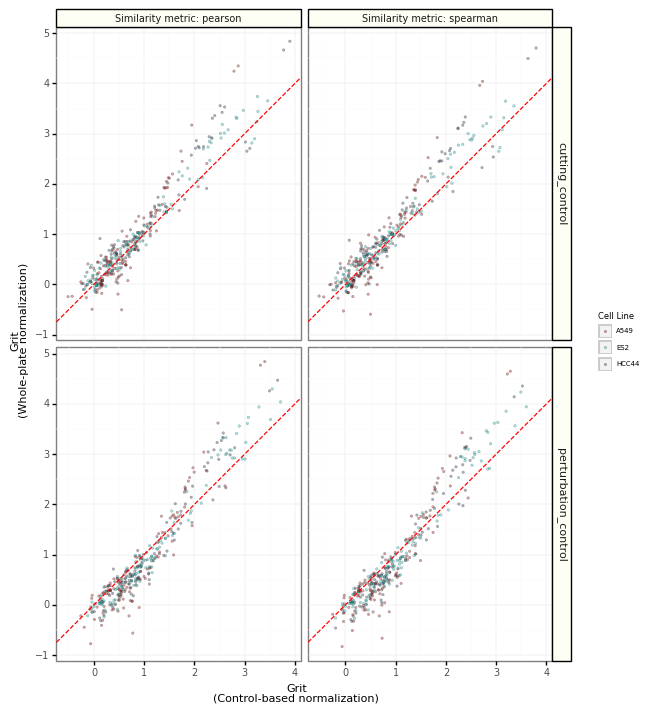

<ggplot: (395207596)>

In [7]:
def col_func(s):
    return f"Similarity metric: {s}"

norm_control_gg = (
    gg.ggplot(grit_full_df, gg.aes(x="grit_control", y="grit_wholeplate"))
    + gg.geom_point(gg.aes(fill="cell_line"), alpha=0.4, size=1, stroke=0.1)
    + gg.geom_abline(intercept=0, slope=1, color="red", linetype="dashed")
    + gg.facet_grid("barcode_control~cor_method", labeller=gg.labeller(cols=col_func))
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.coord_fixed()
    + gg.xlab("Grit\n(Control-based normalization)")
    + gg.ylab("Grit\n(Whole-plate normalization)")
    + gg.theme_bw()
    + grit_theme
)

output_file = pathlib.Path(f"{output_dir}/cell_health_grit_platenormalization_comparison.png")
norm_control_gg.save(output_file, dpi=500, height=3, width=6.5)

norm_control_gg

In [8]:
# What is the Spearman correlation between the four above facets
(
    grit_full_df
    .groupby(["barcode_control", "cor_method"])
    .corr(method="spearman")
    .reset_index()
    .drop(["level_2", "grit_wholeplate"], axis="columns")
    .query("grit_control != 1")
    .rename({
        "grit_control": "spearman_correlation_between_grit"
    }, axis="columns")
    .reset_index(drop=True)
)

,barcode_control,cor_method,spearman_correlation_between_grit
0,cutting_control,pearson,0.936744
1,cutting_control,spearman,0.930880
2,perturbation_control,pearson,0.942317
3,perturbation_control,spearman,0.936867
